In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# from collections.abc import Sequence
from typing import Sequence
import torch
import numpy as np
import time

_SSM_NAME = "JackFram/llama-160m"
_LLM_NAME = 'openlm-research/open_llama_3b_v2'
device = "cuda"

assert torch.cuda.is_available()
tokenizer = AutoTokenizer.from_pretrained(_SSM_NAME)
ssm = AutoModelForCausalLM.from_pretrained(_SSM_NAME).cuda()
llm = AutoModelForCausalLM.from_pretrained(_LLM_NAME, torch_dtype=torch.float16).cuda().eval()

/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def _create_token_tree(
    expansion_config: Sequence[int],
    prompt: str,
    tokenizer: AutoTokenizer,
    model: AutoModelForCausalLM,
    has_kv_cache: bool = False,
):
    """Create token tree following Figure 3 in the paper.

    We don't need "real" tokens for our experiments - just
    random integers would work too - but might as well.

    Figure 3 illustrates the <k1, k2, ...> expansion approach they
    use to create token trees. We can use each of the top_k tokens from
    a single model to create the same tree structure.

    Args:
        expansion_config: A sequence of integers representing how much to
            branch at each generation step.
        prompt: Initial prompt.
        tokenizer: HF tokenizer.
        model: HF generative model.
    """
    assert expansion_config
    current_tree = tokenizer(prompt, return_tensors="pt").input_ids.cuda()
    if has_kv_cache:
        assert tokenizer.add_bos_token
        current_tree = current_tree[:, 1:]
    else:
        current_tree = current_tree[:, :-1]
    # assert current_tree.shape[-1] == 4
    for k in expansion_config:
        output = model.generate(
            current_tree,
            max_new_tokens=1,
            return_dict_in_generate=True,
            output_scores=True,
        )
        # Take the top_k tokens from the 1 generation step we've done
        top_k = torch.topk(output.scores[-1], k=k, dim=-1).indices.reshape(-1, 1)
        current_tree = torch.repeat_interleave(current_tree, k, dim=0)
        # Join the top_k tokens to the current tree
        current_tree = torch.cat((current_tree, top_k), dim=-1)

    return current_tree

In [4]:
import torch

def _invert_4d_attention_mask(attention_mask: torch.Tensor, kv_cache_num_tokens: int=0) -> torch.Tensor:
    """For 4D masks, new HF requires us to invert the mask so it doesn't modify it at all."""
    # The attention mask must have last 2 dims shape [current seq len, KV cache size + current seq len]
    # So we prepend a tensor of 1s to allow attending to the full KV cache
    assert attention_mask.dim() == 4
    if kv_cache_num_tokens > 0:
        attention_mask = torch.cat(
            (
                torch.ones(
                    attention_mask.shape[0],
                    attention_mask.shape[1],
                    attention_mask.shape[2],
                    kv_cache_num_tokens,
                ).to(device),
                attention_mask,
            ),
            dim=-1,
        )
    # Invert the mask: 0s to -inf and 1s to 0 (0 means attention allowed)
    min_dtype = torch.finfo(torch.float32).min
    attention_mask.masked_fill_(attention_mask == 0, min_dtype)
    attention_mask.masked_fill_(attention_mask == 1, 0.0)
    return attention_mask

def construct_tree_model_inputs(sequences):
    # input_1 = torch.unique(torch.flatten(sequences), sorted=False)
    flat = torch.flatten(sequences).tolist()
    unique = []
    for tok in flat:
        if tok not in unique:
            unique.append(tok)
    # input is list of unique tokens
    input_1 = torch.tensor([unique]).to(device)

    a = input_1.shape[-1]
    mask_1 = np.zeros((a, a), dtype=np.float32)
    positions = [-1] * len(unique)
    
    for seq in sequences:
        branch_progress = []
        for (pos, tok) in enumerate(seq):
            input_1_idx = unique.index(tok)
            positions[input_1_idx] = pos
            branch_progress.append(input_1_idx)
            for idx in branch_progress:
                mask_1[input_1_idx][idx] = 1
    mask_1 = torch.tensor(mask_1, device=device)
    mask_1 = mask_1.unsqueeze(0).unsqueeze(0).to(device)
    position_ids_1 = torch.tensor([positions], device=device, dtype=torch.int64)
    return (input_1, mask_1, position_ids_1)

In [5]:
def _create_dummy_kv_cache(
    kv_cache_num_tokens: int,
    batch_size: int,
    num_attention_heads: int,
    hidden_size: int,
    num_layers: int,
):
    k = torch.rand(
        batch_size,
        num_attention_heads,
        kv_cache_num_tokens,
        hidden_size // num_attention_heads,
        dtype=torch.float16,
    ).to(device)
    v = torch.rand(
        batch_size,
        num_attention_heads,
        kv_cache_num_tokens,
        hidden_size // num_attention_heads,
        dtype=torch.float16,
    ).to(device)
    return tuple((k, v) for _ in range(num_layers))

In [6]:
from torch.nn.attention import SDPBackend, sdpa_kernel

def time_normal(input_ids, model: AutoModelForCausalLM, kv_cache=None):
   with sdpa_kernel(SDPBackend.FLASH_ATTENTION), torch.inference_mode():
            model(input_ids=input_ids, past_key_values=kv_cache, use_cache=kv_cache is not None)

def time_tree(input_ids, mask, position_ids, model: AutoModelForCausalLM, kv_cache=None):
    with torch.autocast(device_type='cuda', dtype=torch.float16), torch.inference_mode():
        model(input_ids=input_ids, attention_mask=mask, position_ids=position_ids, past_key_values=kv_cache, use_cache=kv_cache is not None)

In [17]:
from torch.profiler import profile, ProfilerActivity, schedule

# Guide: https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html

_N_ITERATIONS = 10
_WAIT_STEPS = 1
_WARMUP_STEPS = 1
schedule_params = {
    'wait': _WAIT_STEPS,
    'warmup': _WARMUP_STEPS,
    'active': _N_ITERATIONS - _WAIT_STEPS - _WARMUP_STEPS,
}
profiler_kwargs = {
    'activities': [ProfilerActivity.CPU, ProfilerActivity.CUDA],
    'profile_memory': True,
    'schedule': schedule(**schedule_params),
    'record_shapes': True,
    'with_stack': True,
    'on_trace_ready': torch.profiler.tensorboard_trace_handler('./log'),
}

from torch.nn.attention import SDPBackend, sdpa_kernel


def print_normal_profile_stats(input, model):
    # with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True, enable_cudnn=False):
    with torch.inference_mode(), profile(**profiler_kwargs) as prof:
        for _ in range(_N_ITERATIONS):
            model(input_ids=input)
            prof.step()
    # print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

def print_tree_profile_stats(input, mask, position_ids, model):
    # with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True, enable_cudnn=False):
    with torch.inference_mode(), profile(**profiler_kwargs) as prof:
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            for _ in range(_N_ITERATIONS):
                model(input_ids=input, attention_mask=mask, position_ids=position_ids)
                prof.step()
    # print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [24]:
expansion_config = (8, 1, 1, 1, 1, 1, 1)

# del llm
# llm = AutoModelForCausalLM.from_pretrained(_LLM_NAME).cuda().eval()
token_tree = _create_token_tree(
        expansion_config=expansion_config,
        prompt="The",
        tokenizer=tokenizer,
        model=ssm,
)

# kv_cache_sequential = _create_dummy_kv_cache(
#         kv_cache_num_tokens=2,
#         batch_size=7,
#         num_attention_heads=llm.config.num_attention_heads,
#         hidden_size=llm.config.hidden_size,
#         num_layers=llm.config.num_hidden_layers
#     )
# time_normal(token_tree, llm, kv_cache=kv_cache_sequential)
print(token_tree.shape)
print_normal_profile_stats(token_tree, llm)

tree_input, tree_mask, tree_position_ids = construct_tree_model_inputs(token_tree)
tree_mask = _invert_4d_attention_mask(tree_mask)
print(tree_input.shape)
# time_tree(tree_input, tree_mask, tree_position_ids, llm)
print_tree_profile_stats(tree_input, tree_mask, tree_position_ids, llm)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
STAGE:2024-06-03 00:30:37 993875:993875 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


torch.Size([8, 8])


STAGE:2024-06-03 00:30:38 993875:993875 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-06-03 00:30:38 993875:993875 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


torch.Size([1, 22])


STAGE:2024-06-03 00:30:43 993875:993875 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-06-03 00:30:43 993875:993875 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-06-03 00:30:43 993875:993875 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [10]:
print(token_tree.shape)
# tree_input.shape

torch.Size([7, 11])


In [69]:
# Optionally use the context manager to ensure one of the fused kernels is run
import torch.nn.functional as F
query = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
key = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
value = torch.rand(32, 8, 128, 64, dtype=torch.float16, device="cuda")
mask = torch.rand(32, 1, 128, 128, dtype=torch.float16, device="cuda")
with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True, enable_cudnn=False):
    F.scaled_dot_product_attention(query,key,value, mask)

/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


In [21]:
from transformers import utils

utils.is_flash_attn_2_available()

True

In [9]:
import torch


params = torch.backends.cuda.SDPAParams(
    torch.ones(1, 1, 3, 8, dtype=torch.float16).cuda(),
    torch.ones(1, 1, 5, 8, dtype=torch.float16).cuda(),
    torch.ones(1, 1, 5, 8, dtype=torch.float16).cuda(),
    None,
    # torch.ones(1, 1, 3, 3, dtype=torch.float16).cuda(),
    0.0,
    False
)

torch.backends.cuda.can_use_flash_attention(params, debug=True)

True

In [20]:
# Measure max memory allocated
import gc

def reset_memory():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.synchronize()

def end_memory_collection():
    torch.cuda.synchronize()
    max_mem_gb = torch.cuda.max_memory_allocated() / 1024**3
    return max_mem_gb

token_tree = _create_token_tree([2, 2, 2], "The good dog is", tokenizer, ssm)
reset_memory()
time_normal(token_tree, llm, kv_cache=None)
seq_max_mem_gb = end_memory_collection()

tree_input, tree_mask, tree_position_ids = construct_tree_model_inputs(token_tree)
tree_mask = _invert_4d_attention_mask(tree_mask)
reset_memory()
time_tree(input_ids=tree_input, mask=tree_mask, position_ids=tree_position_ids, model=llm, kv_cache=None)
tree_max_mem_gb = end_memory_collection()

print(f"Normal: {seq_max_mem_gb} GB")
print(f"Tree: {tree_max_mem_gb} GB")

past key values None
past key values None
past key values None
Normal: 19.76176118850708 GB
Tree: 19.75322389602661 GB


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


tensor([[    1,   450,  1781, 11203, 29892,   278,  1781, 11203],
        [    1,   450,  1781, 11203, 29892,   278,  1781,  8023],
        [    1,   450,  1781, 11203, 29892,   278,  4319, 11203],
        [    1,   450,  1781, 11203, 29892,   278,  4319,   697],
        [    1,   450,  1781, 11203, 29892,  1058,   338,   263],
        [    1,   450,  1781, 11203, 29892,  1058,   338,   451],
        [    1,   450,  1781, 11203, 29892,  1058,   756,  1063],
        [    1,   450,  1781, 11203, 29892,  1058,   756,   263],
        [    1,   450,  1781, 11203,   338,   263,  1781, 11203],
        [    1,   450,  1781, 11203,   338,   263,  1781,  2022],
        [    1,   450,  1781, 11203,   338,   263,  2107, 11203],
        [    1,   450,  1781, 11203,   338,   263,  2107, 18708],
        [    1,   450,  1781, 11203,   338,   278,   697,  1058],
        [    1,   450,  1781, 11203,   338,   278,   697,   393],
        [    1,   450,  1781, 11203,   338,   278,  1900, 11203],
        [ 

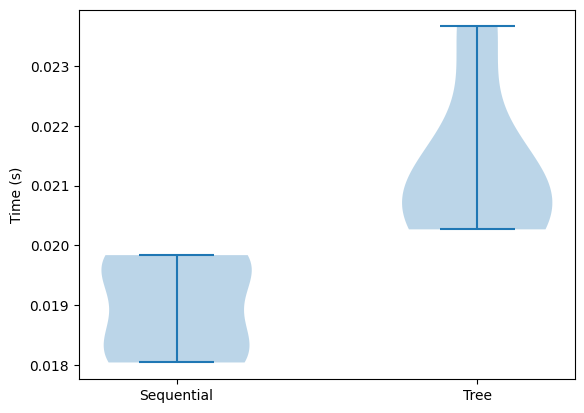

In [42]:
import torch.utils.benchmark as benchmark
import numpy as np
import matplotlib.pyplot as plt

N_ITERATIONS = 32

tree_widths = [4] #range(1, 4)
sequential_times = []
tree_times = []

kv_cache_num_tokens = 128

for tree_width in tree_widths:
    expansion_config = (3, 2, 2, 2)

    token_tree = _create_token_tree(
        expansion_config=expansion_config,
        prompt="The good dog is",
        tokenizer=tokenizer,
        model=ssm,
    )
    print(token_tree)

    batch_size=np.prod(expansion_config)
    # kv_cache_sequential = _create_dummy_kv_cache(
    #     kv_cache_num_tokens=kv_cache_num_tokens,
    #     batch_size=batch_size,
    #     num_attention_heads=llm.config.num_attention_heads,
    #     hidden_size=llm.config.hidden_size,
    #     num_layers=llm.config.num_hidden_layers
    # )
    
    sequential_timer = benchmark.Timer(
        stmt="time_normal(input_ids, model, kv_cache)",
        setup="from __main__ import time_normal",
        num_threads=1,
        globals={
            'input_ids': token_tree,
            'model': llm,
            'kv_cache': None
        },
        label="Sequential"
    )
    sequential_measurement = sequential_timer.blocked_autorange(min_run_time=1)
    
    # print(len(sequential_measurement.times))
    # print(sequential_measurement.mean)
    # sequential_times.append(sequential_measurement.times[-1])
    
    # construct inputs for tree decoding
    # kv_cache_tree = _create_dummy_kv_cache(
    #     kv_cache_num_tokens=kv_cache_num_tokens,
    #     batch_size=1,
    #     num_attention_heads=llm.config.num_attention_heads,
    #     hidden_size=llm.config.hidden_size,
    #     num_layers=llm.config.num_hidden_layers
    # )
    tree_input, tree_mask, tree_position_ids = construct_tree_model_inputs(token_tree)
    # print(tree_input, tree_mask, tree_position_ids)
    # Required for 4D mask support in new HF
    tree_mask = _invert_4d_attention_mask(tree_mask, kv_cache_num_tokens)

    tree_timer = benchmark.Timer(
        stmt="time_tree(input_ids, mask, position_ids, model, kv_cache)",
        setup="from __main__ import time_tree",
        num_threads=1,
        globals={
            'input_ids': tree_input,
            'mask': tree_mask,
            'position_ids': tree_position_ids,
            'model': llm,
            'kv_cache': None
        },
        label="Tree"
    )
    tree_measurement = tree_timer.blocked_autorange(min_run_time=1)
    # tree_times.append(tree_measurement.times[-1])
    plt.violinplot([sequential_measurement.times, tree_measurement.times])
    plt.xticks([1, 2], ['Sequential', 'Tree'])
    plt.ylabel("Time (s)")
    # print_normal_profile_stats(token_tree, llm)
    # print_tree_profile_stats(tree_input, tree_mask, tree_position_ids, llm)

In [24]:
sequential_measurement.times

[0.023301942087709904,
 0.02941708788275719,
 0.020992765948176385,
 0.01949091162532568,
 0.019095754623413085,
 0.018749571591615676,
 0.01875303257256746,
 0.018825798481702804,
 0.019142610020935535,
 0.018783524073660372,
 0.018862470984458923,
 0.01920093595981598,
 0.01937845628708601,
 0.01909222677350044,
 0.01909434553235769,
 0.019495926797389984,
 0.019066131114959715,
 0.019196340441703798,
 0.019186932034790515,
 0.018816653825342654,
 0.018964203633368017,
 0.018911480344831942,
 0.0189549857750535,
 0.019206176698207855,
 0.019027856551110743,
 0.019313684292137624]

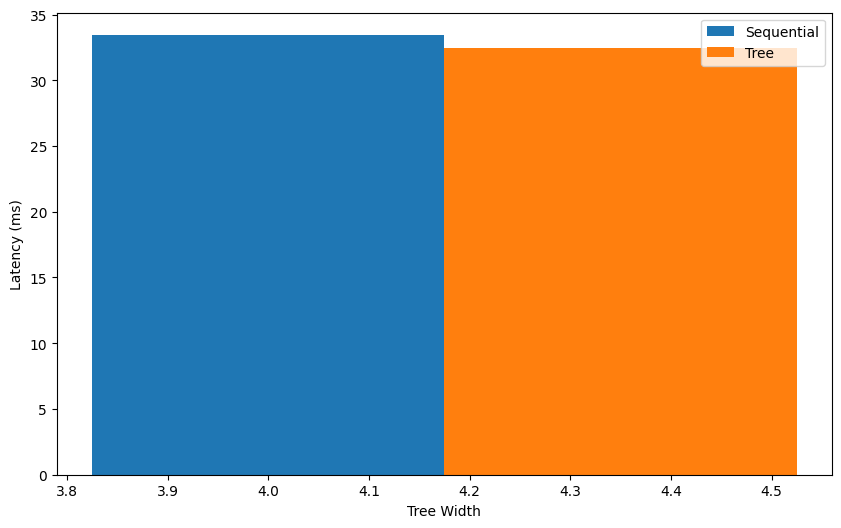

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
import numpy as np

width = 0.35
plt.figure(figsize=(10, 6))

x_data = tree_widths
y_sequential = np.array(sequential_times) * 1000 # scale to ms
plt.bar(x_data, y_sequential, label="Sequential", width=width)  # Plot the first list as the y-axis values
y_tree = np.array(tree_times) * 1000 # scale to ms
plt.bar([pos + width for pos in x_data], y_tree, label="Tree", width=width)  # Plot the second list as the y-axis values

plt.xlabel("Tree Width")
plt.ylabel("Latency (ms)")
plt.legend()

plt.show()
plt.savefig("tree_vs_sequential.png")

In [10]:
import metrics
from transformers import AutoConfig

mistral_7b_config = AutoConfig.from_pretrained("mistralai/Mistral-7B-v0.1")

metrics.identify_compute_memory_bound(
    gpu=metrics.T4,
    token_batch=torch.ones(1, np.sum(np.cumprod(expansion_config))),
    dtype=torch.float32,
    num_layers=mistral_7b_config.num_hidden_layers,
    d_model=mistral_7b_config.hidden_size,
    n_head=mistral_7b_config.num_attention_heads,
    vocab_size=mistral_7b_config.vocab_size,
    kv_cache_token_count=0
)

Memory-bound: arithmetic intensity 7.448872654272583 < 27.0


/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
import itertools 
import numpy as np
import matplotlib.pyplot as plt
import pickle

def generate_expansion_configs(config_length, min_expansion, max_expansion):
    values = [i for i in range(min_expansion, max_expansion)]
    result = list(itertools.product(values, repeat=config_length))
    return result

expansion_configs = []
for length in range(2, 4):
    expansion_configs.extend(generate_expansion_configs(length, 2, 6))
kv_sizes = [0, 2, 4, 8, 16, 64, 128]

def construct_data_dict(seq_dict, tree_dict, param):
    data_dict = {}
    for config in expansion_configs:
        data_dict[str(config)] = []
        for kv_size in kv_sizes:
            overall_conf = str(config) + ", " + str(kv_size)
            if (overall_conf in seq_dict):
                diff = seq_dict[overall_conf][param] - tree_dict[overall_conf][param]
                if (param == 0):
                    diff = min(0.03, diff) * 1000 # cap at 0.03 and convert to ms
                elif (param == 2):
                    diff = -diff
                data_dict[str(config)].append(diff)
            else:
                data_dict[str(config)].append(0.0)
    return data_dict

# Custom normalization
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint
        rescaled = (result - vmin) / (vmax - vmin)  # rescale to [0, 1]
        rescaled = np.ma.masked_where(np.isnan(rescaled), rescaled)
        if midpoint is not None:
            midpoint_rescaled = (midpoint - vmin) / (vmax - vmin)
            rescaled = np.where(rescaled < midpoint_rescaled,
                                0.5 * rescaled / midpoint_rescaled,
                                0.5 + 0.5 * (rescaled - midpoint_rescaled) / (1 - midpoint_rescaled))
        if is_scalar:
            rescaled = rescaled[0]
        return rescaled

In [12]:
from matplotlib.colors import TwoSlopeNorm

def construct_graphs(seq_dict, tree_dict, flash):
    params = {0: "Time"} #{0: "Time", 1: "Memory Usage (GB)", 2: "GPU Utilization"}
    for param in params:
        data_dict = construct_data_dict(seq_dict, tree_dict, param)
        data = np.array(list(data_dict.values())).T
        
        # Create the heat map
        fig, ax = plt.subplots(figsize=(36,8)) 

        # Ensure vmin and vmax are correctly calculated from the data
        # vmin = np.min(data)
        # vmax = np.max(data)
        # midpoint = 0  # Midpoint set to 0 to emphasize negative values
        
        # #norm = MidpointNormalize(vmin=np.min(data), vmax=np.max(data), midpoint=0)  # Adjust midpoint as needed
        # norm = TwoSlopeNorm(vmin=vmin, vcenter=midpoint, vmax=v)
        cax = ax.matshow(data, cmap='coolwarm', vmax=30, vmin=-30)
        
        # Add a colorbar to show the scale
        colorbar = fig.colorbar(cax)
        
        # Set ticks on the colorbar at smaller intervals
        num_ticks = 30  # Number of ticks you want
        ticks = np.linspace(np.min(data), np.max(data), num_ticks)
        colorbar.set_ticks(ticks)
        
        # Increase colorbar font size
        # colorbar.ax.tick_params(labelsize=12)
        
        # Set x and y axis ticks and labels
        ax.set_xticks(np.arange(len(data_dict.keys())))
        ax.set_xticklabels(data_dict.keys(), fontsize=6)
        ax.set_yticks(np.arange(len(kv_sizes)))
        ax.set_yticklabels(kv_sizes)
        
        ax.set_xticks(np.arange(len(data_dict.keys())))
        ax.set_xticklabels(data_dict.keys())
        ax.set_yticks(np.arange(len(kv_sizes)))
        ax.set_yticklabels(kv_sizes)
        
        # Add labels and title
        title = 'Measured '+ params[param]+ ' Difference between Sequential Decoding and Tree Decoding'
        if (flash):
            title += ': W/ Flash'
        else:
            title += ': W/O Flash'
        plt.title(title)
        plt.xticks(rotation=25)
        plt.xlabel('Tree Configs')
        plt.ylabel('KV-Cache Sizes')
        
        # Display the plot
        plt.show()

In [11]:
# FLASH GRAPHS
import pickle
seq_flash = open("a6000_results/sequential_a6000_no_flash.pkl",'rb')
# tree_flash = open("a6000_results/tree_a6000_flash.pkl", 'rb')
seq = pickle.load(seq_flash)
# tree = pickle.load(tree_flash)

# construct_graphs(seq, tree, True)
seq

{'(2, 2), 0': [0.024929723143577574, 13.284029483795166, 46],
 '(2, 2), 2': [0.024440141282975676, 13.2891845703125, 24],
 '(2, 2), 4': [0.02488932781284902, 13.29436206817627, 29],
 '(2, 2), 8': [0.02500509927049279, 13.304693222045898, 22],
 '(2, 2), 16': [0.02504010661505163, 13.325355529785156, 3],
 '(2, 2), 64': [0.025269933603703977, 13.457170486450195, 26],
 '(2, 2), 128': [0.025264171417802572, 13.615817070007324, 26],
 '(2, 3), 0': [0.024481710530817512, 13.337069511413574, 42],
 '(2, 3), 2': [0.02457269417440019, 13.34327220916748, 48],
 '(2, 3), 4': [0.024810061454772946, 13.35102653503418, 24],
 '(2, 3), 8': [0.024968260808325395, 13.366511344909668, 34],
 '(2, 3), 16': [0.02439493299802629, 13.397480964660645, 36],
 '(2, 3), 64': [0.02434758193790913, 13.582741260528564, 37],
 '(2, 3), 128': [0.0243980011834604, 13.833343029022217, 29],
 '(2, 4), 0': [0.024170648705746447, 13.387051105499268, 21],
 '(2, 4), 2': [0.02534786476753652, 13.395830154418945, 25],
 '(2, 4), 4': [

In [7]:
import metrics

ratio = metrics.T4.tflops / metrics.T4.memory_bandwidth_tb_s
ratio

216.66666666666669

In [11]:
import itertools
import metrics
import numpy as np


for expansion_config in itertools.product(range(2, 4), range(2, 6)):
    print(expansion_config, np.cumprod(expansion_config))
    metrics.identify_compute_memory_bound(
        gpu=metrics.A6000,
        token_batch=torch.ones(np.prod(expansion_config), 2),
        dtype=torch.float16,
        num_layers=llm.config.num_hidden_layers,
        d_model=llm.config.hidden_size,
        n_head=llm.config.num_attention_heads,
        vocab_size=llm.config.vocab_size,
        kv_cache_token_count=0
    )

(2, 2) [2 4]
Memory-bound: arithmetic intensity 7.961373880097445 < 216.66666666666669
(2, 3) [2 6]
Memory-bound: arithmetic intensity 11.912696481263469 < 216.66666666666669
(2, 4) [2 8]
Memory-bound: arithmetic intensity 15.844634928186505 < 216.66666666666669
(2, 5) [ 2 10]
Memory-bound: arithmetic intensity 19.75733151222353 < 216.66666666666669
(3, 2) [3 6]
Memory-bound: arithmetic intensity 11.912696481263469 < 216.66666666666669
(3, 3) [3 9]
Memory-bound: arithmetic intensity 17.803379614323855 < 216.66666666666669
(3, 4) [ 3 12]
Memory-bound: arithmetic intensity 23.650927135458634 < 216.66666666666669
(3, 5) [ 3 15]
Memory-bound: arithmetic intensity 29.455811118934115 < 216.66666666666669


In [12]:
for expansion_config in itertools.product(range(2, 4), range(2, 6)):
    print(expansion_config, np.cumprod(expansion_config))
    metrics.identify_compute_memory_bound(
        gpu=metrics.,
        token_batch=torch.ones(1, np.sum(np.cumprod(expansion_config))),
        dtype=torch.float16,
        num_layers=llm.config.num_hidden_layers,
        d_model=llm.config.hidden_size,
        n_head=llm.config.num_attention_heads,
        vocab_size=llm.config.vocab_size,
        kv_cache_token_count=0
    )

(2, 2) [2 4]
Memory-bound: arithmetic intensity 5.9794024886444825 < 216.66666666666669
(2, 3) [2 6]
Memory-bound: arithmetic intensity 7.963234837709746 < 216.66666666666669
(2, 4) [2 8]
Memory-bound: arithmetic intensity 9.942325458489549 < 216.66666666666669
(2, 5) [ 2 10]
Memory-bound: arithmetic intensity 11.91662078559219 < 216.66666666666669
(3, 2) [3 6]
Memory-bound: arithmetic intensity 8.95337622651857 < 216.66666666666669
(3, 3) [3 9]
Memory-bound: arithmetic intensity 11.91662078559219 < 216.66666666666669
(3, 4) [ 3 12]
Memory-bound: arithmetic intensity 14.868956957276781 < 216.66666666666669
(3, 5) [ 3 15]
Memory-bound: arithmetic intensity 17.810208693110937 < 216.66666666666669
